<a href="https://colab.research.google.com/github/rrl7012005/Deep-Learning-PyTorch/blob/main/Deploying_a_Vision_Transformer_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import and load everything

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [ ]:
!pip install torchinfo

from torchinfo import summary

In [ ]:
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:

    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 27.18 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

train_dir = image_path / "train"
test_dir = image_path / "test"

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

Replicating papers is a good way to showcase machine learning skills and talents.

In [ ]:
height = 224
width = 224
color_channels = 3
patch_size = 16

num_patches = (height * width) // (patch_size ** 2)
num_patches

196

Turn image into patches. First visualize

(-0.5, 223.5, 223.5, -0.5)

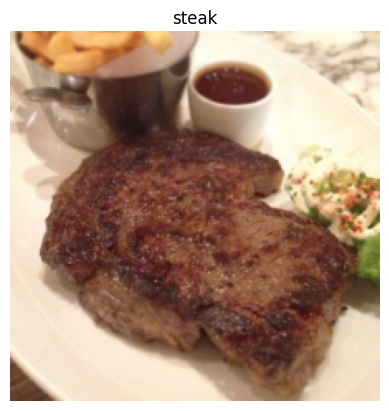

In [ ]:
image, label = next(iter(train_dataloader))

image = image[0]
label = label[0]

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

Visualize top row of patches

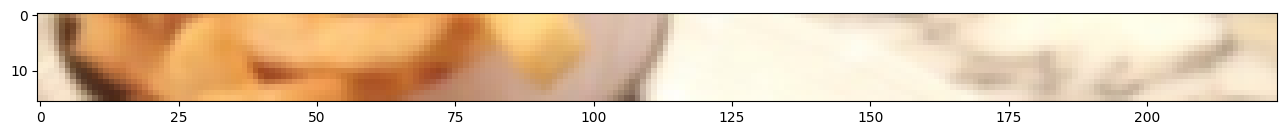

In [ ]:
image = image.permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image[:patch_size, :, :])

Visualize top row as patches

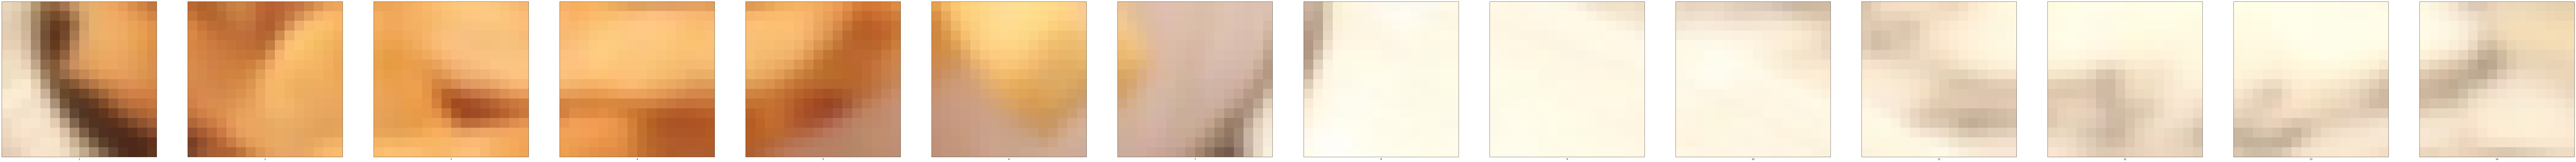

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=IMG_SIZE // patch_size,
                        figsize=(num_patches, num_patches), sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0, IMG_SIZE, patch_size)):
    axs[i].imshow(image[:patch_size, patch:patch + patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Do it for the whole image

In [ ]:
fig, axs = plt.subplots(nrows=IMG_SIZE // patch_size,
                        ncols=IMG_SIZE // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True, sharey=True)

for i, patch_height in enumerate(range(0, IMG_SIZE, patch_size)):
  for j, patch_width in enumerate(range(0, IMG_SIZE, patch_size)):
    axs[i, j].imshow(image[patch_height:patch_height + patch_size,
                           patch_width:patch_width + patch_size,
                           :])

    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")

    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]}")
plt.show()

In ViTs the input sequence can also be formed from feature maps of a CNN, where each patch is now a convolutional filter applied to that section of an image. In other words the patch passed through a kernel filter. This is done for embd_dim number of channels and then the patch dimension is flattened.

The image starts as a 2D image
(224, 224, 3) and after passing through the conv layer we should get a (14, 14, 768) which is then flattened to a (196, 768) where the embedding of each patch is each of the 768 convolutional filters applied to that section of the image. This replaces the embedding matrix. Both methods are equivalent.

In [ ]:
conv2d = nn.Conv2d(in_channels=color_channels,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

image = image.permute(2, 1, 0)
print(image.shape, patch_size)

image_after_conv = conv2d(image.unsqueeze(0)) #need a batch dim
image_after_conv.shape

torch.Size([3, 224, 224]) 16


torch.Size([1, 768, 14, 14])

Lets visualize 5 random feature maps

[562, 1, 183, 24, 262]


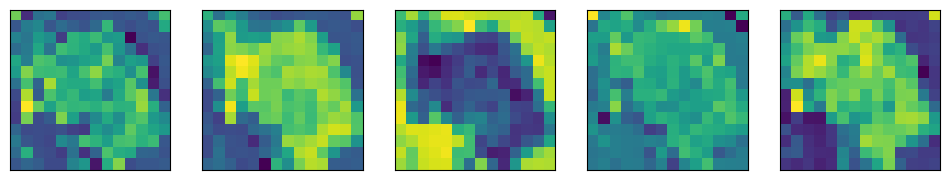

In [ ]:
import random

rand_idxs = random.sample(range(0, 768), k=5)

print(rand_idxs)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(rand_idxs):
  image_feature_map = image_after_conv[:, idx, :, :]
  axs[i].imshow(image_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Flatten the patches and permute dimensions

In [ ]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

image_after_flatten = flatten(image_after_conv).permute(0, 2, 1)
image_after_flatten.shape

torch.Size([1, 196, 768])

#Building the ViT

##Embeddings

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels:int=3, patch_size:int=16, emb_dim:int=768):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=emb_dim,
                          kernel_size=patch_size,
                          stride=patch_size,
                          padding=0)

    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    x = self.conv(x)
    x = self.flatten(x)
    x = x.permute(0, 2, 1)

    return x

In [ ]:
set_seeds()

embedder = PatchEmbedding()

print(image.unsqueeze(0).shape)
print(embedder(image.unsqueeze(0)).shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])


In [ ]:
summary(model=embedder,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
PatchEmbedding                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d: 1-1                            [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten: 1-2                           [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

We need a classification token as well where all the information should end up, and is the part we feed into the final MLP. Its embedding is non position related and is learnable.

In [ ]:
batch_size = 1
embd_dim = 768

class_token = nn.Parameter(torch.ones(batch_size, 1, embd_dim), requires_grad=True) #trainable

class_token.shape, class_token[:, :, :10]

(torch.Size([1, 1, 768]),
 tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>))

Position embeddings used in ViTs are only 1D learnable embeddings as there is no significant gain from using 2D position embeddings.

In [ ]:
pos_embd = nn.Parameter(torch.ones(1, num_patches+1, embd_dim))

pos_embd.shape, pos_embd[:, :10, :10]

(torch.Size([1, 197, 768]),
 tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>))

##Attention Layers and MLP

In [ ]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self, embd_dim:int=768, num_heads:int=12, attn_dropout:float=0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(embd_dim)

    self.mha = nn.MultiheadAttention(embed_dim = embd_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.mha(query=x, key=x, value=x, need_weights=False)

    return attn_output

In [ ]:
mhsab = MultiHeadAttentionBlock()

print(image_after_flatten.shape)
print(mhsab(image_after_flatten).shape)

torch.Size([1, 196, 768])
torch.Size([1, 196, 768])


MLP. This is a projection onto a higher dimensional space, apply a non-linearity then project back to our original space.

In [ ]:
class MLP(nn.Module):
  def __init__(self, embd_dim:int=768, mlp_dim:int=3072, dropout:float=0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(embd_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embd_dim,
                  out_features=mlp_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(in_features=mlp_dim,
                  out_features=embd_dim),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)

    return x


In [ ]:
mlp = MLP()

print(image_after_flatten.shape)
print(mlp(image_after_flatten).shape)
#

torch.Size([1, 196, 768])
torch.Size([1, 196, 768])


##Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self, embd_dim:int=768, num_heads:int=12, mlp_dim:int=3072, dropout:float=0.1):
    super().__init__()

    self.mha = MultiHeadAttentionBlock(embd_dim=embd_dim, num_heads=num_heads, attn_dropout=dropout)
    self.mlp = MLP(embd_dim=embd_dim, mlp_dim=mlp_dim, dropout=dropout)

  def forward(self, x):
    x = x + self.mha(x) #Res connections
    x = x + self.mlp(x)

    return x

In [ ]:
encoder = Encoder()
summary(model=encoder,
        input_size=(1, 197, 768))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 197, 768]             --
├─MultiHeadAttentionBlock: 1-1           [1, 197, 768]             --
│    └─LayerNorm: 2-1                    [1, 197, 768]             1,536
│    └─MultiheadAttention: 2-2           [1, 197, 768]             2,362,368
├─MLP: 1-2                               [1, 197, 768]             --
│    └─LayerNorm: 2-3                    [1, 197, 768]             1,536
│    └─Sequential: 2-4                   [1, 197, 768]             --
│    │    └─Linear: 3-1                  [1, 197, 3072]            2,362,368
│    │    └─GELU: 3-2                    [1, 197, 3072]            --
│    │    └─Dropout: 3-3                 [1, 197, 3072]            --
│    │    └─Linear: 3-4                  [1, 197, 768]             2,360,064
│    │    └─Dropout: 3-5                 [1, 197, 768]             --
Total params: 7,087,872
Trainable params: 7,087,872
Non-tr

There is also a built in Transformer Encoder layer, and the whole transformer encoder and probably the decoder as well in pytorch

In [ ]:
nn.TransformerEncoderLayer(d_model=768,
                           nhead=12,
                           dim_feedforward=3072,
                           dropout=0.1,
                           activation="gelu",
                           batch_first=True,
                           norm_first=True)

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

This makes it very easy to use transformers

##Transformer

Now make the entire transformer itself

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               embd_dim:int=768,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_heads:int=12,
               mlp_dim:int=3072,
               attn_dropout:float=0,
               dropout:float=0.1,
               num_classes:int=3,
               num_layers:int=12):
    super().__init__()

    self.num_patches = (img_size * img_size) // (patch_size ** 2)
    self.class_embd = nn.Parameter(torch.randn(1, 1, embd_dim), requires_grad=True)

    self.pos_embd = nn.Parameter(torch.randn(1, self.num_patches+1, embd_dim), requires_grad=True)
    self.embd_dropout = nn.Dropout(dropout)

    self.patch_embd = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, emb_dim=embd_dim)

    self.encoder = nn.Sequential(*[Encoder(embd_dim=embd_dim, num_heads=num_heads, mlp_dim=mlp_dim, dropout=dropout) for _ in range(num_layers)])

    self.classifier = nn.Sequential(
        nn.LayerNorm(embd_dim),
        nn.Linear(embd_dim, num_classes)
    )

  def forward(self, x):

    batch_size = x.shape[0]
    class_token = self.class_embd.expand(batch_size, -1, -1)

    x = self.patch_embd(x)

    x = torch.cat((class_token, x), dim=1)

    x = x + self.pos_embd

    x = self.embd_dropout(x)

    x = self.encoder(x)

    x = x[:, 0, :]

    x = self.classifier(x)

    return x

In [ ]:
summary(model=ViT(), input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─Sequential: 1-3                             [1, 197, 768]             --
│    └─Encoder: 2-3                           [1, 197, 768]             --
│    │    └─MultiHeadAttentionBlock: 3-1      [1, 197, 768]             2,363,904
│    │    └─MLP: 3-2                          [1, 197, 768]             4,723,968
│    └─Encoder: 2-4                           [1, 197, 768]             --
│    │    └─MultiHeadAttentionBlock: 3-3      [1, 197, 768]             2,363,904
│    │    └─MLP: 3-4                          [1, 197, 768]     

##Training the ViT

In [ ]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=ViT().parameters(), lr=3e-3,
                             betas=(0.9, 0.999), weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(model=ViT(),
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)



Now it would be stupid to run this on the food dataset. 85 million parameters vs 200 datapoints will fail instantly.

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

##Use a pretrained ViT

In [ ]:
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
transforms = weights.transforms()

vit = torchvision.models.vit_b_16(weights=weights)

for parameter in vit.parameters():
  parameter.requires_grad = False

set_seeds()

#Change classifier
vit.heads = nn.Linear(768, 3).to(device)


In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=transforms,
                                                                                                     batch_size=32)

Train

In [ ]:
from going_modular.going_modular import engine


optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


set_seeds()
pretrained_vit_results = engine.train(model=vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

plot_loss_curves(pretrained_vit_results)

Save the model

In [ ]:
from going_modular.going_modular import utils
import pathlib

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

vit_model_size = pathlib.Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
vit_model_size

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


327

#Deploying ViT

When deploying you have to keep in mind the use case of the model and performance optimizations for that use case.

Models are typically deployed on-device which is very fast, doesn't need internet however the computing power may be limited and the storage space as well. Or on the cloud where you can use as much computing power as your servers have, and can deploy one model but everyone can use it. However, costs can get high and predictions can be slower perhaps due to latency. Theres privacy concerns as well.

You can also consider whether your model will be online (real-time) where inference happens immediately or offline (batch) where predictions happen periodically example photos app classifies images.

Models can be deployed using several tools. For on-device use Google's ML Kit or Apple's Core ML.
For the cloud AWS, Azure, Hugging Face can be used. APIs such as FastAPI, TFServe, TorchServe can be used or something likeONNX can be used for general.

An API is a way for 2 computers to interact with each other. If your model was deployed as an API, write a program to send data to it and then receive predictions back.

Start small, a simple deployment method is to turn the model into a demo app with Gradio and then deploy it on Hugging Face Spaces.

Remember speed is almost as important if not sometimes more important than accuracy, and to achieve a high accuracy always fine tune or transfer learn, unless you have access to millions of dollars and supercomputers and thousands to tens of thousands of datapoints at least.

In [ ]:
!pip -q install gradio
import gradio as gr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.2 MB/s eta 0:00:00


Our inputs will be images of food, and the output be the model outputs. Gradio emulates this by creating an interface gradio.Interface(fn, inputs, outputs) where fn is the Python function. We need a function that does predictions from scratch inputs.

In [ ]:
from typing import Tuple, Dict
import timeit

def predict(img) -> Tuple[Dict, float]:

  start_time = timeit.timer()

  img = transforms(img).unsqueeze(0).to(device)

  vit.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(vit(img), dim=1)

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timeit.timer() - start_time, 5)

  return pred_labels_and_probs, pred_time

Test this function.

In [ ]:
import random
from PIL import Image
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_img_path = random.choice(test_data_paths)

img = Image.open(test_img_path)

pred_dict, pred_time = predict(img=image)

NameError: name 'test_dir' is not defined

The gradio interface also takes a list of example images as an optional parameter for a demo.

In [ ]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]

Now we build the gradio interface ad launch it with gradio.Interface.launch.

We have to specify the types of inputs and outputs we expect, its a gradio image, and the outputs are a gradio number for the time and a label for the class.

In [ ]:
title = "FoodVision Mini"
description = "A ViT Feature extractor image classification model into pizza, steak or sushi"
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

demo = gr.Interface(fn=predict, inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                    gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, share=True) #shareable link expires in 72h

This only lasts temporarily for a permanent deployment, consider hugging face spaces, a resource allowing us to host and share ML apps, essentially the GitHub for machine learning.

First we need to put everything in one directory.

demos/  
└── foodvision_mini/  
    ├──
     09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth  
    ├── app.py  
    ├── examples/  
    │   ├── example_1.jpg  
    │   ├── example_2.jpg  
    │   └── example_3.jpg   
    ├── model.py  
    └── requirements.txt  


app.py contains the Gradio app (the default name for hugging face spaces)

model.py contains the model definition  and any transformations

requirements contains the package version

In [ ]:
import shutil

foodvision_path = Path("demos/foodvision_mini/")

if foodvision_path.exists():
  shutil.rmtree(foodvision_path) #remove existing files

foodvision_path.mkdir(parents=True, exist_ok=True)

In [ ]:
!ls -a demos/foodvision_mini/

.  ..


Create the examples directory

In [ ]:
foodvision_ex_path = foodvision_path / "examples"

if foodvision_ex_path.exists():
  shutil.rmtree(foodvision_ex_path)

foodvision_ex_path.mkdir(parents=True, exist_ok=True)

foodvision_examples = [Path('data/pizza_steak_sushi/test/sushi/1230335.jpg'),
                      Path('data/pizza_steak_sushi/test/steak/354513.jpg'),
                      Path('data/pizza_steak_sushi/test/pizza/1152100.jpg')]

for ex in foodvision_examples:
  destination = foodvision_ex_path / ex.name
  shutil.copy2(src=ex, dst=destination)

Get our list of examples

In [ ]:
import os

examples_list = [["examples/" + example] for example in os.listdir(foodvision_ex_path)]
examples_list

[['examples/1152100.jpg'], ['examples/1230335.jpg'], ['examples/354513.jpg']]

Move our model to the directory. Write the model onto a script.

In [ ]:
vit_path = "models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth"

vit_dstn = foodvision_path / vit_path.split("/")[-1]

try:
  shutil.move(src=vit_path, dst=vit_dstn)
except:
  print(f"File {vit_path} already moved")
  print(vit_dstn.exists())

In [ ]:
%%writefile demos/foodvision_mini/model.py

from torch import nn


def vit_model(num_classes:int=3, seed:int=42):

    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()

    vit = torchvision.models.vit_b_16(weights=weights)

    for parameter in vit.parameters():
      parameter.requires_grad = False

    set_seeds()

    vit.heads = nn.Linear(768, 3).to(device)

    return vit, transforms

Now we write app.py which is the script to convert the model to a gradio demo. We need to load the saved model and do inference.

In [ ]:
import gradio as gr
import os
import torch

from model import vit_model
from timeit import default_timer as timer
from typing import Tuple, Dict

class_names = ["pizza", "steak", "sushi"]

vit, vit_transforms = vit_model(num_classes=3)

vit_path = "models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth"

vit.load_state_dict(torch.load(f=vit_path, map_location=torch.device("cpu")))

def predict(img) -> Tuple[Dict, float]:

  start_time = timer()

  img = transforms(img).unsqueeze(0).to(device)

  vit.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(vit(img), dim=1)

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 5)

  return pred_labels_and_probs, pred_time

title = "FoodVision Mini"
description = "A ViT Feature extractor image classification model into pizza, steak or sushi"
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

examples_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(fn=predict, inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                    gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, share=True)

Lets create the requirements file as well

In [ ]:
torch.__version__, torchvision.__version__, gr.__version__

('2.4.1+cu121', '0.19.1+cu121', '4.44.0')

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt

torch==2.4.1+cu121
torchvision==0.19.1+cu121
gradio==4.44.0

Now we actually deploy to hugging face spaces, we can upload via the interface or via the command line.

In [ ]:
!ls demos/foodvision_mini/

examples


We need to download our files to upload to hugging face so zip them up

In [ ]:
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache_*" "*ipynb_checkpoints*"

In [ ]:
from google.colab import files
files.download("demos/foodvision_mini.zip")

To run this model locally instead of deploying it to hugging spaces, unzip it, go into the foodvision_mini directory, create a virtual environment, activate it, install the requirements and run the app

In [ ]:
!cd foodvision_mini
!python3 -m venv env
!source env/bin/activate
!pip install -r requirements.txt #-r is for recursive
!python3 app.py

To deploy to hugging face spaces, select gradio as the space sdk, clone the repo locally in terminal, move the downloaded folder into the cloned repo. To upload and track large files we need to install git lfs !git lfs install. Then just follow the rest of the steps to deploy.

We can repeat this again with the full version of the Food101 dataset with 101 classes and 100,000 datapoints. However colab cuts my GPU access quickly, and I do not have the computing power to hyperparameter tune a model this big.